데이터 로드 완료: 2037 개의 음식점 데이터
TF-IDF 행렬 생성 완료: (2037, 142)


TypeError: sparse array length is ambiguous; use getnnz() or shape[0]

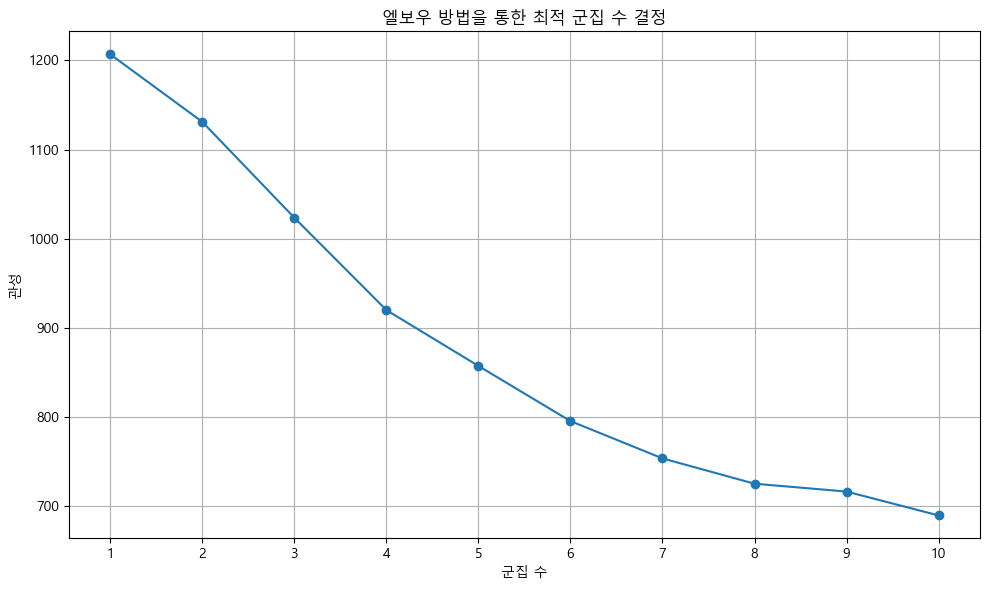

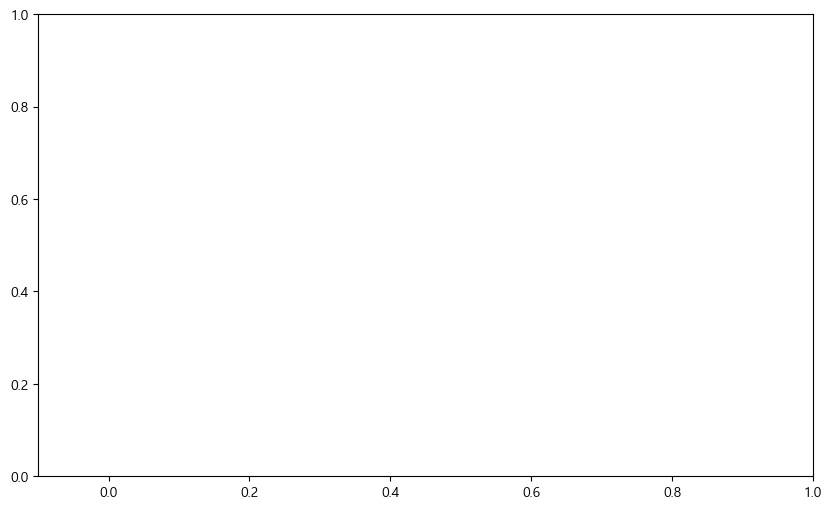

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_samples, silhouette_score
import os
import json
import ast

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 경우
# plt.rcParams['font.family'] = 'AppleGothic'  # macOS의 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

class RestaurantClusterAnalyzer:
    def __init__(self, file_path=None):
        self.df = None
        self.tfidf = None
        self.tfidf_matrix = None
        self.cosine_sim = None
        
        if file_path:
            self.load_data(file_path)
    
    def load_data(self, file_path):
        """데이터 로드 함수"""
        try:
            self.df = pd.read_csv(file_path, encoding='utf-8')
            print(f"데이터 로드 완료: {len(self.df)} 개의 음식점 데이터")
            self.preprocess_data()
            self.create_tfidf_matrix()
        except Exception as e:
            print(f"데이터 로드 중 오류 발생: {e}")
            # 다른 인코딩 시도
            try:
                self.df = pd.read_csv(file_path, encoding='cp949')
                print(f"cp949 인코딩으로 데이터 로드 완료: {len(self.df)} 개의 음식점 데이터")
                self.preprocess_data()
                self.create_tfidf_matrix()
            except Exception as e2:
                print(f"데이터 로드 재시도 중 오류 발생: {e2}")
    
    def preprocess_data(self):
        """데이터 전처리 함수"""
        # 결측치 처리
        self.df = self.df.fillna("")
        
        # 태그 정보 처리
        if '음식점_태그' in self.df.columns:
            self.df['음식점_태그'] = self.df['음식점_태그'].apply(self.parse_json_field)
            
            # 특징 추출
            self.df["combined_features"] = self.df.apply(self.combine_features, axis=1)
        else:
            print("'음식점_태그' 열이 데이터프레임에 없습니다.")
    
    @staticmethod
    def parse_json_field(json_str):
        """JSON 형태의 문자열을 파싱하는 함수"""
        if isinstance(json_str, str):
            try:
                return ast.literal_eval(json_str)
            except:
                try:
                    return json.loads(json_str)
                except:
                    return json_str
        return json_str
    
    @staticmethod
    def combine_features(row):
        """태그 정보를 결합하는 함수"""
        # 태그 추출
        tags = ""
        if isinstance(row["음식점_태그"], list):
            tags = " ".join([tag["tags"] for tag in row["음식점_태그"] if "tags" in tag])
        return f"{tags}".strip()
    
    def create_tfidf_matrix(self):
        """TF-IDF 행렬 생성 함수"""
        if "combined_features" in self.df.columns:
            # TF-IDF 벡터화
            self.tfidf = TfidfVectorizer(stop_words='english')
            self.tfidf_matrix = self.tfidf.fit_transform(self.df["combined_features"])
            
            # 코사인 유사도 계산
            self.cosine_sim = cosine_similarity(self.tfidf_matrix, self.tfidf_matrix)
            print(f"TF-IDF 행렬 생성 완료: {self.tfidf_matrix.shape}")
        else:
            print("'combined_features' 열이 데이터프레임에 없습니다.")
    
    def find_optimal_clusters(self, max_clusters=10):
        """최적의 군집 수를 찾는 함수 (엘보우 방법)"""
        if self.tfidf_matrix is None:
            print("TF-IDF 행렬이 생성되지 않았습니다.")
            return
        
        inertia_values = []
        
        for k in range(1, max_clusters + 1):
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(self.tfidf_matrix)
            inertia_values.append(kmeans.inertia_)
        
        # 엘보우 그래프 그리기
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
        plt.title('엘보우 방법을 통한 최적 군집 수 결정')
        plt.xlabel('군집 수')
        plt.ylabel('관성')
        plt.xticks(range(1, max_clusters + 1))
        plt.grid(True)
        plt.tight_layout()
        
        return inertia_values
    
    def silhouette_plot(self, n_clusters):
        """실루엣 분석을 통한 군집 평가"""
        if self.tfidf_matrix is None:
            print("TF-IDF 행렬이 생성되지 않았습니다.")
            return
        
        # KMeans 모델 학습
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(self.tfidf_matrix)
        
        # 실루엣 점수 계산
        silhouette_avg = silhouette_score(self.tfidf_matrix, cluster_labels)
        sample_silhouette_values = silhouette_samples(self.tfidf_matrix, cluster_labels)
        
        # 그래프 생성
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(10, 6)
        
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(self.tfidf_matrix) + (n_clusters + 1) * 10])
        
        y_lower = 10
        for i in range(n_clusters):
            # i번째 클러스터의 실루엣 점수 추출
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)
            
            # 클러스터 레이블 표시
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            
            # 다음 클러스터를 위한 y_lower 업데이트
            y_lower = y_upper + 10
        
        ax1.set_title("클러스터별 실루엣 분석")
        ax1.set_xlabel("실루엣 계수 값")
        ax1.set_ylabel("클러스터 레이블")
        
        # 평균 실루엣 점수 표시
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # y축 눈금 제거
        ax1.set_xticks(np.arange(-0.1, 1.1, 0.1))
        
        plt.tight_layout()
        
        print(f"n_clusters={n_clusters}에 대한 평균 실루엣 점수: {silhouette_avg:.3f}")
        
        return silhouette_avg
    
    def visualize_kmeans_clusters(self, n_clusters=5):
        """K-means를 사용한 음식점 태그 데이터 군집화 및 시각화"""
        if self.tfidf_matrix is None:
            print("TF-IDF 행렬이 생성되지 않았습니다.")
            return
        
        # 1. K-means 군집화 수행
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(self.tfidf_matrix)
        
        # 2. t-SNE를 사용하여 고차원 데이터를 2차원으로 축소
        print("t-SNE 차원 축소 시작... (시간이 다소 소요될 수 있습니다)")
        tsne = TSNE(n_components=2, perplexity=min(30, self.tfidf_matrix.shape[0]-1), 
                   n_iter=300, random_state=42, verbose=1)
        reduced_data = tsne.fit_transform(self.tfidf_matrix.toarray())
        print("t-SNE 차원 축소 완료")
        
        # 3. 시각화
        plt.figure(figsize=(12, 8))
        
        # 각 클러스터별로 다른 색상으로 표시
        colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
        
        for i in range(n_clusters):
            # 해당 클러스터에 속하는 데이터 포인트만 선택
            cluster_points = reduced_data[clusters == i]
            
            # 클러스터별로 산점도 그리기
            plt.scatter(
                cluster_points[:, 0], 
                cluster_points[:, 1], 
                s=50, 
                c=[colors[i]], 
                label=f'클러스터 {i+1}'
            )
        
        # 클러스터 중심점 표시
        centers = kmeans.cluster_centers_
        if centers.shape[1] > 2:  # 중심점도 t-SNE로 변환해야 하는 경우
            centers_2d = tsne.fit_transform(centers)
        else:
            centers_2d = centers
            
        plt.scatter(
            centers_2d[:, 0], 
            centers_2d[:, 1], 
            s=200, 
            c='magenta', 
            marker='X', 
            label='중심점'
        )
        
        # 일부 대표 음식점 이름을 그래프에 표시
        for i, (x, y) in enumerate(reduced_data):
            # 일정 간격으로만 레이블 표시 (예: 20개마다)
            if i % 20 == 0 and i < len(self.df):
                plt.annotate(
                    self.df.iloc[i]['음식점_이름'] if '음식점_이름' in self.df.columns else f"음식점 {i}",
                    (x, y),
                    fontsize=8,
                    alpha=0.7
                )
        
        plt.title('K-means 군집화: 음식점 태그 기반')
        plt.xlabel('t-SNE 특성 1')
        plt.ylabel('t-SNE 특성 2')
        plt.legend()
        plt.tight_layout()
        
        # 4. 각 클러스터의 대표 태그 찾기
        cluster_tags = {}
        for i in range(n_clusters):
            # 해당 클러스터에 속하는 음식점들의 인덱스
            cluster_indices = np.where(clusters == i)[0]
            
            # 해당 클러스터의 모든 태그 수집
            all_tags = []
            for idx in cluster_indices:
                if idx < len(self.df) and '음식점_태그' in self.df.columns:
                    if isinstance(self.df.iloc[idx]['음식점_태그'], list):
                        for tag_dict in self.df.iloc[idx]['음식점_태그']:
                            if 'tags' in tag_dict:
                                all_tags.append(tag_dict['tags'])
            
            # 가장 많이 등장한 태그 5개 추출
            if all_tags:
                tag_counts = pd.Series(all_tags).value_counts()
                top_tags = tag_counts.head(5).index.tolist()
                cluster_tags[f'클러스터 {i+1}'] = top_tags
            else:
                cluster_tags[f'클러스터 {i+1}'] = ["태그 없음"]
        
        # 클러스터별 대표 태그 출력
        print("\nK-means 클러스터별 대표 태그:")
        for cluster, tags in cluster_tags.items():
            print(f"{cluster}: {', '.join(tags)}")
        
        # 실루엣 계수 계산
        if len(np.unique(clusters)) > 1:  # 클러스터가 2개 이상인 경우에만 계산
            silhouette_avg = silhouette_score(self.tfidf_matrix, clusters)
            print(f"\n클러스터 평균 실루엣 계수: {silhouette_avg:.3f}")
        
        # 데이터프레임에 클러스터 정보 추가
        self.df['kmeans_cluster'] = clusters
        
        return clusters, reduced_data
    
    def visualize_dbscan_clusters(self, eps=0.5, min_samples=5):
        """DBSCAN을 사용한 음식점 태그 데이터 군집화 및 시각화"""
        if self.tfidf_matrix is None:
            print("TF-IDF 행렬이 생성되지 않았습니다.")
            return
        
        # 1. DBSCAN 군집화 수행
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(self.tfidf_matrix)
        
        # 클러스터 수 확인
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)
        
        print(f"DBSCAN 군집화 결과: {n_clusters}개의 클러스터와 {n_noise}개의 노이즈 포인트가 식별되었습니다.")
        
        # 2. t-SNE를 사용하여 고차원 데이터를 2차원으로 축소
        print("t-SNE 차원 축소 시작... (시간이 다소 소요될 수 있습니다)")
        tsne = TSNE(n_components=2, perplexity=min(30, self.tfidf_matrix.shape[0]-1), 
                   n_iter=300, random_state=42, verbose=1)
        reduced_data = tsne.fit_transform(self.tfidf_matrix.toarray())
        print("t-SNE 차원 축소 완료")
        
        # 3. 시각화
        plt.figure(figsize=(12, 8))
        
        # 노이즈 포인트 먼저 그리기
        noise_points = reduced_data[clusters == -1]
        if len(noise_points) > 0:
            plt.scatter(
                noise_points[:, 0],
                noise_points[:, 1],
                s=30,
                c='gray',
                alpha=0.5,
                label='노이즈'
            )
        
        # 각 클러스터별로 다른 색상으로 표시
        colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters))
        
        for i, cluster_id in enumerate(sorted(set(clusters) - {-1})):
            # 해당 클러스터에 속하는 데이터 포인트만 선택
            cluster_points = reduced_data[clusters == cluster_id]
            
            # 클러스터별로 산점도 그리기
            plt.scatter(
                cluster_points[:, 0], 
                cluster_points[:, 1], 
                s=50, 
                c=[colors[i]], 
                label=f'클러스터 {cluster_id}'
            )
        
        # 일부 대표 음식점 이름을 그래프에 표시
        for i, (x, y) in enumerate(reduced_data):
            # 일정 간격으로만 레이블 표시 (예: 20개마다)
            if i % 20 == 0 and i < len(self.df):
                plt.annotate(
                    self.df.iloc[i]['음식점_이름'] if '음식점_이름' in self.df.columns else f"음식점 {i}",
                    (x, y),
                    fontsize=8,
                    alpha=0.7
                )
        
        plt.title(f'DBSCAN 군집화: 음식점 태그 기반 (eps={eps}, min_samples={min_samples})')
        plt.xlabel('t-SNE 특성 1')
        plt.ylabel('t-SNE 특성 2')
        plt.legend()
        plt.tight_layout()
        
        # 4. 각 클러스터의 대표 태그 찾기
        cluster_tags = {}
        for cluster_id in sorted(set(clusters)):
            # 해당 클러스터에 속하는 음식점들의 인덱스
            cluster_indices = np.where(clusters == cluster_id)[0]
            
            # 해당 클러스터의 모든 태그 수집
            all_tags = []
            for idx in cluster_indices:
                if idx < len(self.df) and '음식점_태그' in self.df.columns:
                    if isinstance(self.df.iloc[idx]['음식점_태그'], list):
                        for tag_dict in self.df.iloc[idx]['음식점_태그']:
                            if 'tags' in tag_dict:
                                all_tags.append(tag_dict['tags'])
            
            # 가장 많이 등장한 태그 5개 추출
            if all_tags:
                tag_counts = pd.Series(all_tags).value_counts()
                top_tags = tag_counts.head(5).index.tolist()
                label = '노이즈' if cluster_id == -1 else f'클러스터 {cluster_id}'
                cluster_tags[label] = top_tags
            else:
                label = '노이즈' if cluster_id == -1 else f'클러스터 {cluster_id}'
                cluster_tags[label] = ["태그 없음"]
        
        # 클러스터별 대표 태그 출력
        print("\nDBSCAN 클러스터별 대표 태그:")
        for cluster, tags in cluster_tags.items():
            print(f"{cluster}: {', '.join(tags)}")
        
        # 실루엣 계수 계산 (노이즈 포인트 제외)
        if n_clusters > 1:
            # 노이즈 포인트를 제외한 데이터와 클러스터 레이블
            non_noise_mask = clusters != -1
            non_noise_data = self.tfidf_matrix[non_noise_mask]
            non_noise_labels = clusters[non_noise_mask]
            
            if len(np.unique(non_noise_labels)) > 1 and len(non_noise_labels) > 1:
                silhouette_avg = silhouette_score(non_noise_data, non_noise_labels)
                print(f"\n클러스터 평균 실루엣 계수 (노이즈 제외): {silhouette_avg:.3f}")
        
        # 데이터프레임에 클러스터 정보 추가
        self.df['dbscan_cluster'] = clusters
        
        return clusters, reduced_data


# 메인 실행 코드
if __name__ == "__main__":
    # 파일 경로 설정
    current_dir = os.getcwd()
    project_root = os.path.abspath(os.path.join(current_dir, '../..'))
    file_path = os.path.join(project_root, 'data/preprocessed/google_gangnam_crawling_data_cleaned.csv')
    
    # 파일이 존재하지 않으면 현재 디렉토리에서 찾기
    if not os.path.exists(file_path):
        file_path = os.path.join(os.getcwd(), 'google_gangnam_crawling_data_cleaned.csv')
    
    # 분석기 초기화 및 데이터 로드
    analyzer = RestaurantClusterAnalyzer(file_path)
    
    # 최적의 군집 수 찾기 (엘보우 방법)
    analyzer.find_optimal_clusters(max_clusters=10)
    
    # 실루엣 분석으로 군집 평가
    for k in range(2, 6):
        analyzer.silhouette_plot(k)
    
    # K-means 군집화 및 시각화
    analyzer.visualize_kmeans_clusters(n_clusters=4)
    
    # DBSCAN 군집화 및 시각화
    analyzer.visualize_dbscan_clusters(eps=0.5, min_samples=5)


In [ ]:
import plotly.express as px

# 지도에 음식점 위치 표시
fig = px.scatter_mapbox(df, lat='위도', lon='경도', color='카테고리',
                        size='리뷰_수', hover_name='음식점_이름',
                        hover_data=['주소', '평균_가격'],
                        zoom=12, height=600)
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
